__Author:__ Ryan Harper

# Bike Accident Forecasting for Portland, Oregon

__Background:__ Portland, Oregon is a big biking city in the US. PDOT reports that about [7%](https://www.portlandoregon.gov/transportation/article/629951) of the PDX workforce commute by bike. As a result, there have been an equally large number of [reported cyclist accidents/collisions](https://bikeportland.org/2015/04/21/portland-mapped-every-reported-traffic-injury-2004-13-139742). In 2012, police attempted to reduce the number of accidents by passing out [traffic violations](https://www.oregonlive.com/portland/index.ssf/2012/08/police_stop_and_cite_50_cyclis.html) to cyclists. In recent years, the Portland Department of Transportation attempted to make more roads bike friendly with the [20s Bikeway Project](https://www.portlandoregon.gov/transportation/62816), but some [local news reports](https://www.portlandmercury.com/blogtown/2018/04/16/19813860/cars-are-still-killing-lots-of-bicyclists-and-pedestrians) still suggest that the rate of bike accidents is increasing.

__Project:__ The goal of this project is to create a forecasting method that establishes a metric for measuring whether or not the number of bike accidents in subsequent years is higher or lower than the estimate. Ideally, this would be used to monitor what effects projects like the 20s Bikeway Project might have with regards to the frequency of bike accidents in Portland.

__Hypothesis:__ I predict that there will be a positive upward trend in bike accidents for Portland, Oregon (Multnomah County). There will also be trends for the time of day, day of the week, and season of the year.

------

In [1]:
import missingno as msno;from pprint import pprint;import pandas as pd;import matplotlib.pyplot as plt;import sklearn
import seaborn as sns; import numpy as np;from numpy.polynomial.polynomial import polyfit;from scipy.stats import linregress
from statsmodels.tsa.stattools import acf, pacf;from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA,AR;from sklearn.metrics import mean_squared_error;import matplotlib as mpl
from sklearn.linear_model import SGDRegressor;from fbprophet import Prophet;import statsmodels.api as sm
import warnings;warnings.filterwarnings('ignore')
pd.set_option('display.show_dimensions',False)

/Users/ryan/.local/share/virtualenvs/thinkful-Xo17phXs/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])


## Data Cleaning

In [2]:
accidentsdf = pd.read_csv('../data/odot/Multnomah.csv',low_memory=False);accidentsdf.head(8)

,Crash ID,Record Type,Vehicle ID,Participant ID,Participant Display Seq#,Vehicle Coded Seq#,Participant Vehicle Seq#,Serial #,Crash Month,Crash Day,...,Participant Cause 1 Code,Participant Cause 2 Code,Participant Cause 3 Code,Participant Event 1 Code,Participant Event 2 Code,Participant Event 3 Code,BAC Test Results Code,Alcohol Use Reported,Drug Use Reported,Participant Striker Flag
0,1449628,1,NaN,NaN,NaN,NaN,NaN,149.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1449628,2,2741421.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1449628,3,2741421.0,3130945.0,1.0,1,1.0,NaN,NaN,NaN,...,13.0,,,,,,,,,0.0
3,1449628,2,2741422.0,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1449628,3,2741422.0,3130946.0,2.0,2,1.0,NaN,NaN,NaN,...,0.0,,,,,,,,,0.0
5,1449632,1,NaN,NaN,NaN,NaN,NaN,135.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1449632,2,2741429.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1449632,3,2741429.0,3130953.0,1.0,1,1.0,NaN,NaN,NaN,...,0.0,,,,,,,0,0,0.0


_There are a lot of empty values and the crash id appears to exist in more than one row._ 

<br>_Let's look at just one crash id:_

In [3]:
accidentsdf[accidentsdf['Crash ID'] == 1456243]

,Crash ID,Record Type,Vehicle ID,Participant ID,Participant Display Seq#,Vehicle Coded Seq#,Participant Vehicle Seq#,Serial #,Crash Month,Crash Day,...,Participant Cause 1 Code,Participant Cause 2 Code,Participant Cause 3 Code,Participant Event 1 Code,Participant Event 2 Code,Participant Event 3 Code,BAC Test Results Code,Alcohol Use Reported,Drug Use Reported,Participant Striker Flag
8765,1456243,1,NaN,NaN,NaN,NaN,NaN,1537.0,1.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8766,1456243,2,2753494.0,NaN,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8767,1456243,3,2753494.0,3144605.0,1.0,1,1.0,NaN,NaN,NaN,...,1.0,,,,,,,,,0.0
8768,1456243,2,2753495.0,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Missing Values Matrix__

Original Data Set - Includes Missing Values


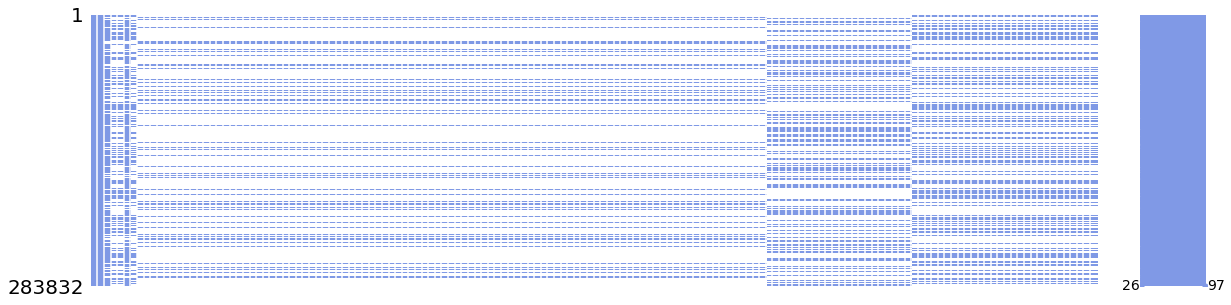

In [4]:
print('Original Data Set - Includes Missing Values');msno.matrix(accidentsdf,fontsize=12,figsize=(20,5),color=(.5,.6,.9));

_In the graph above, white represents missing data, while purple represents real values. Crash ids (in the far left column) appear to include multiple rows for each vehicle/participant/observer, but only one row for each Crash id has data for a majority of the features. This means we can't simply analyze the features as is and have to reduce the data either to the specific participants (2-3 per accident) or to the general accident report (1 per accident)._

<br>_To focus on bicycle accidents, I collect a few random features (unused for this project) and select only rows with a 'Pedalcyclist' count of 1 or more:_

In [5]:
usedcol = ['Crash ID','Crash Hour','Crash Day','Crash Month','Crash Year','Total Pedalcyclist Count',
           'Total Pedalcyclist Fatality Count','Total Pedalcyclist Non-Fatal Injury Count','Crash Type',
           'Collision Type','Median Type','Crash Severity','Intersection Type','Crash ID',
           'Nearest Intersecting Street Number','Road Character']
bikeaccident = accidentsdf[usedcol][accidentsdf['Total Pedalcyclist Count']>0].dropna().reset_index()
print('Training Set: {}\n'.format(len(bikeaccident)))

Training Set: 1473



Cleaned Data Set - No Missing Values


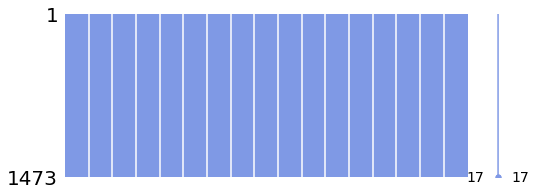

In [6]:
print('Cleaned Data Set - No Missing Values');msno.matrix(bikeaccident,labels=False,figsize=(8,3),color=(.5,.6,.9));

_From this graph, we can see there are a total of 1473 reported ODOT bike related accidents in Multnomah county. The columns are now limited to less than 20 features. This visual looks much better as there is no missing data (represented by white)._

# Data Exploration

_Ok, now I want to explore the features. For example, is there a noticeable difference in time of day for which most accidents occur? My guess would be that most accidents take place when it is dark ~between 7pm-4am._

In [7]:
bikeaccident.index = pd.to_datetime(
    bikeaccident['Crash Year']*10000+bikeaccident['Crash Month']*100+bikeaccident['Crash Day'],format='%Y%m%d')

Total # of Bike Accidents in a Single Week


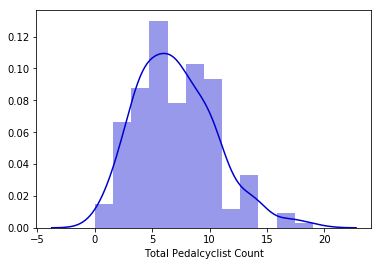

In [8]:
# creating basic time series
ba = bikeaccident['Total Pedalcyclist Count'].groupby(pd.Grouper(freq='W')).count()
sns.distplot(ba,color='mediumblue');print('Total # of Bike Accidents in a Single Week')

Bike Accidents (by hour) w/ Outlier


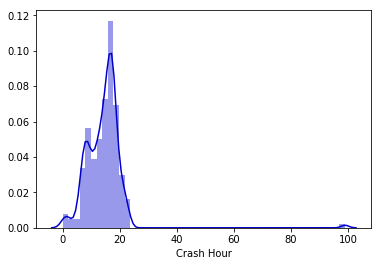

In [9]:
print('Bike Accidents (by hour) w/ Outlier');sns.distplot(bikeaccident['Crash Hour'],color = 'mediumblue');plt.show()

_It seems like there is a random value of 99 that occurs in the data 7 times. This is making the data harder to see, so let's remove it (temporarily). My guess is that 99 represents an unknown hour of the accident as 0 represents midnight._

Bike Accidents (by hour)


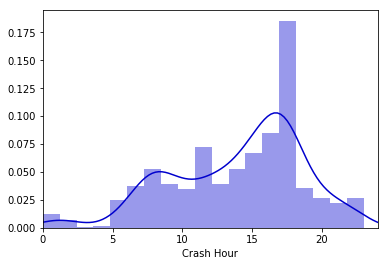

In [10]:
sns.distplot(bikeaccident['Crash Hour'][bikeaccident['Crash Hour']< 99],color='mediumblue');plt.xlim(0,24);print('Bike Accidents (by hour)');plt.show()

_My prediction was wrong. It looks like most accidents happen around evening rush hour (4pm-6pm) with another peak at lunch time, and a third peak during morning rush hour(7am-9am). The data do not appear to be parametric._

<br>_So what about bike deaths? Bike Injuries?_

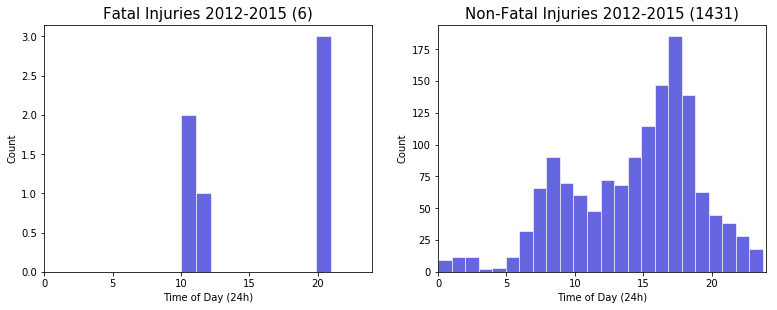

In [11]:
cols = ['Total Pedalcyclist Fatality Count','Total Pedalcyclist Non-Fatal Injury Count']
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.hist(bikeaccident['Crash Hour'][(bikeaccident[cols[0]]>0)],color='mediumblue',edgecolor='white',alpha=.6)
plt.xlim(0,24);plt.xlabel('Time of Day (24h)');plt.ylabel('Count')
plt.title('Fatal Injuries 2012-2015 ({})'.format(bikeaccident['index'][bikeaccident[cols[0]]>0].count()), size=15)

plt.subplot(2,3,2)
plt.hist(bikeaccident['Crash Hour'][(bikeaccident[cols[1]]>0)],bins=100,color='mediumblue',edgecolor='white',alpha=.6)
plt.xlim(0,24);plt.xlabel('Time of Day (24h)');plt.ylabel('Count')
plt.title('Non-Fatal Injuries 2012-2015 ({})'.format(bikeaccident['index'][bikeaccident[cols[1]]>0].count()),size=15)
plt.show()

_3 bike deaths happened at ~9pm, 2 deaths at ~11am, and 1 death at ~noon.<br> <br>NOTE: There is a notice by ODOT with regards to removing confidential data involving fatal accidents so it is likely that the ODOT data set does not accurately reflect the total number of bike deaths from 2012-2015._

In [12]:
ba = bikeaccident['Total Pedalcyclist Count'].groupby(pd.Grouper(freq='W')).count()
bi = bikeaccident['Total Pedalcyclist Count'][bikeaccident['Total Pedalcyclist Non-Fatal Injury Count']>0].groupby(pd.Grouper(freq='W')).count()
bi.sum(),ba.sum(),bi.sum()/ba.sum()

(1431, 1473, 0.9714867617107943)

_Bike injuries account for about 97% of the bike accident data (1431 out of 1473)._

Bike Accidents: Total vs Injured


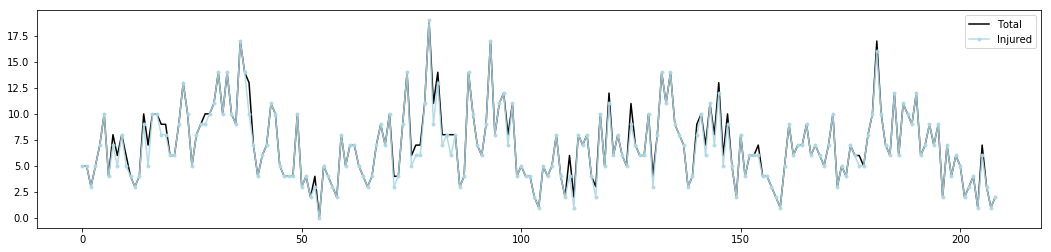

In [13]:
plt.figure(figsize=(18,4))
plt.plot(ba.values,color='black')
plt.plot(bi.values,color='lightblue',linestyle='-',alpha=.9,marker='.')
plt.legend(['Total','Injured']); print('Bike Accidents: Total vs Injured');plt.show()

_The total number of bike accidents is pretty similar to the number of reported injuries per accident. It's probably safe to assume that accidents without injuries don't get reported as frequently. We can infer that this data is a sample subset of a greater unknown._

<br>_Now I will take the rolling mean of the data set to see if any patterns emerge:_

Linear Regression Plot - Full Time Series


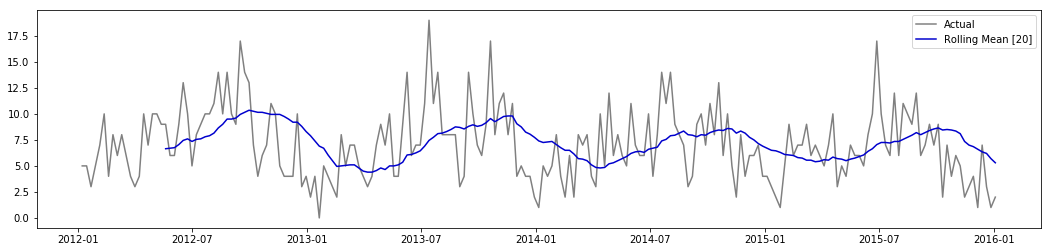

In [14]:
rm = 20
plt.figure(figsize=(18,4))
plt.plot(ba.index,ba.values,color='gray')
plt.plot(ba.index,ba.rolling(window=rm,center=False,axis=0).mean().values,color='mediumblue')
plt.legend(['Actual','Rolling Mean [{}]'.format(rm)]);print('Linear Regression Plot - Full Time Series');plt.show()

_The linear regression line appears to have a sinosoidal distribution for bike accidents from 2012-2015. This suggests that there is a seasonal trend in the data. I suspect that the trend will be on an annual basis._<br> <br>

Bike Accidents by Year (2012-2015)


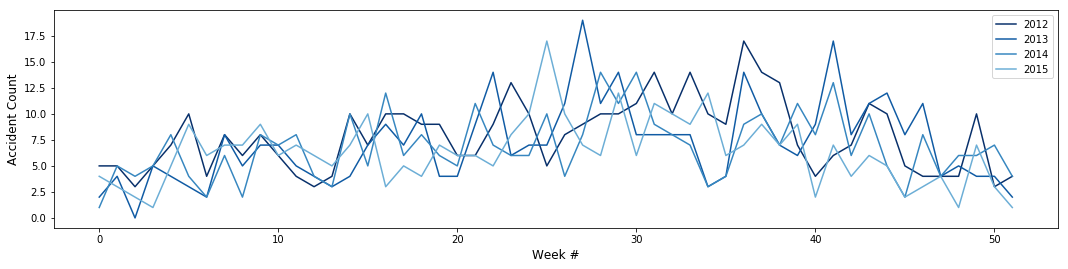

In [15]:
cmap=plt.cm.Blues_r;years = [2012,2013,2014,2015]
yr_plot=[ba.iloc[ba.index.searchsorted(pd.datetime(y, 1, 1)):ba.index.searchsorted(pd.datetime(y, 12, 31))].values for y in years]
plt.figure(figsize=(18,4))
print('Bike Accidents by Year (2012-2015)')
for i,year in enumerate(yr_plot):
    plt.plot(year,color=cmap(i/(len(years)+2)))
plt.legend(years);plt.xlabel('Week #',fontsize=12);plt.ylabel('Accident Count',fontsize=12);plt.show()

_Looking at this graph, there is definitely a seasonal (annual) trend in the data. Summer appears to be the peak time for bike accidents. There could be a number of potential reasons for this: good weather, vacation, and/or new bicyclists. This seasonality is important because it means we can be more accurate in our predictions when we account for seasonality._

Seasonal Decomposition


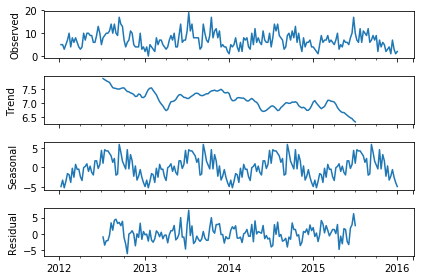

In [16]:
weeks_in_a_year = 52
decomposition = sm.tsa.seasonal_decompose(ba, freq=weeks_in_a_year)
trend,seasonal,residuals = decomposition.trend,decomposition.seasonal,decomposition.resid
decomposition.plot()
print('Seasonal Decomposition')
plt.show()

_Seasonal Decomposition shows that there is both a a seasonal pattern and a downwards trend in the data. I expected an upwards trend in bike accidents because of a rise in population in Portland, so this surprises me._

__[Induce Stationarity](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)__

In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,graph_set=False):
    if graph_set:
        #Determing rolling statistics
        rolmean=timeseries.rolling(window=12).mean()
        rolstd = timeseries.rolling(window=12).std()
        #Plot rolling statistics:
        fig = plt.figure(figsize=(12, 8))
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ba)

Results of Dickey-Fuller Test:
Test Statistic                  -3.539969
p-value                          0.007018
#Lags Used                       4.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


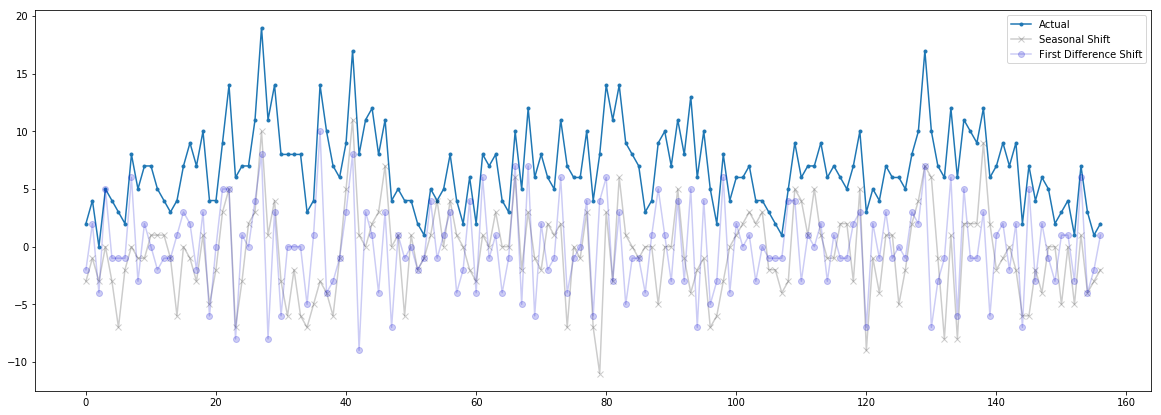

In [18]:
seasonalshift = ba-ba.shift(52)
f1shift = ba.diff()
plt.figure(figsize=(20,7))
plt.plot(ba.iloc[52:].values,marker='.',label='Actual',alpha=1)
plt.plot(seasonalshift.iloc[52:].values,label='Seasonal Shift',color='black',marker='x',alpha=.2)
plt.plot(f1shift.iloc[52:].values,label='First Difference Shift',color='mediumblue',marker='o',alpha=.2)
plt.legend()
plt.show()

_Both the Seasonal and F1 shifts show stationarity while the actual data set has a very slight downwards trend (with the minimum # of accidents never falling below 0). I will use this for SARIMAX and Prophet predictions._

# Predictions

_The goal of this section is to explore a few different regression methods and to evaluate which methods seem to perform better on a sample test set._

__Functions__

In [19]:
RMSE = lambda y_predict, y_actual: np.sqrt(np.sum(np.square(np.subtract(y_predict,y_actual)))/len(y_actual))

def visual_validate(y_pred,y,name,printRMSE=True):
    plt.figure(figsize=(6,2))
    print(name)
    if printRMSE:
        print('RMSE: {}'.format(RMSE(y_pred,y)))
    plt.plot(y,color='gray')
    plt.plot(y_pred,color='mediumblue',linestyle='--')

_The RMSE function will evaluate and compare the results of each model while the visual function will plot the results._

__Test/Train__

In [20]:
lag_split =10
# split into train and test sets
X,y = np.array(range(len(ba.values[1:]))),ba.values[1:]
train, test = [X[:-lag_split],y[:-lag_split]],[X[-lag_split:],y[-lag_split:]]
train_X, train_y = train[0],train[1]
test_X, test_y = test[0],test[1]
N = len(y)
e = np.random.random_sample(N)-.5

_The lagsplit variable determines how big my practice test set will be. I add the noise values(e) to prevent overfitting in my regression models._

### [OLS] Ordinary Least Squares Regression

_Now I want to build my baseline estimator (a straight line). I will create my own linear regression model and compare that to other linear regression estimators._

__Formulas__

Line: $ y = a + bx $<br>
Standard Deviation: $ \sigma=\sqrt {\sum{\frac{(x-\bar{x})^2}n}} $ <br>
Pearson's Correllation Coefficient: $ r= \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x-\bar{x})^2}\sum{(y-\bar{y})^2}}} $<br>
Regression Slope: $ b=r\frac{\sigma_x}{\sigma_y} $ <br>
Root Mean Squared Error: $ \sqrt{\frac{\sum_{i=1}^n {(\hat{y}_{i}- y_{i})}^2}{N}} $

__Functions__

In [21]:
mean = lambda val: val.sum()/len(val)
dif = lambda val: val-mean(val)
r_value = lambda valx,valy:((dif(valx)*dif(valy)).sum())/((((dif(valx)**2).sum())*((dif(valy)**2).sum()))**.5)
std = lambda val:(mean((val-mean(val))**2))**.5
slope = lambda valx,valy: r_value(valx,valy)*std(valy)/std(valx)
intercept = lambda valx,valy: mean(valy) - (slope(valx,valy)*mean(valx))

__Calculations__

In [22]:
x_mean,y_mean = mean(X),mean(y)
x_std,y_std = std(X),std(y)
r = r_value(X,y)
b = slope(X,y)
a = intercept(X,y)
print('Slope: {}\nIntercept: {}\nBaseline RMSE: {}'.format(b,a,RMSE(a+b*X,y)))

Slope: -0.007357059416555984
Intercept: 7.8191479573058515
Baseline RMSE: 3.4128707149346322


_The RMSE value feels pretty high. Considering the data appears have a repeating pattern. I feel confident that I can get a lower RMSE value._

In [23]:
print('Statsmodels: Slope={} Intercept={}'.format(linregress(X,y).slope,linregress(X,y).intercept))
print('Numpy: Slope={} Intercept={}'.format(polyfit(X, y, 1)[1],polyfit(X, y, 1)[0]))

Statsmodels: Slope=-0.007357059416555986 Intercept=7.8191479573058515
Numpy: Slope=-0.007357059416555983 Intercept=7.8191479573058515


_My calculations are the same as Statsmodels and Numpy's internal math! This is a good sign_

__Graph__

Linear Regression Plot - Full Time Series


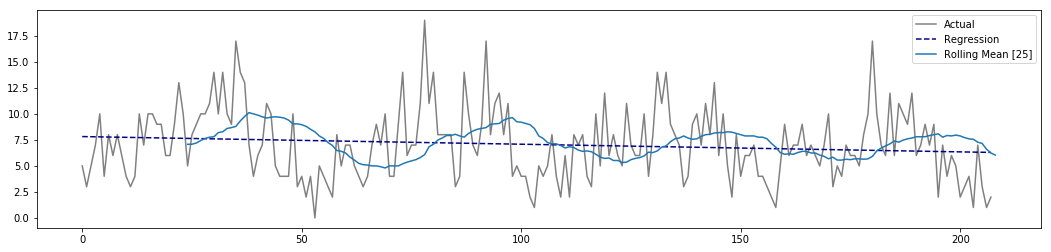

In [24]:
plt.figure(figsize=(18,4));plt.plot(X,y,color='gray');plt.plot(X,a+b*X,color = 'darkblue',linestyle='--')
plt.plot(ba.rolling(window=25,center=False,axis=0).mean().values)
plt.legend(['Actual','Regression','Rolling Mean [25]']);print('Linear Regression Plot - Full Time Series');
plt.show()

_The linear regression line appears to follow a downward trend in bike accidents from 2012-2015 and confirms previous observations with regards to this negative trend._

__Baseline__

Linear Regression [Baseline]
RMSE: 3.519192258080023


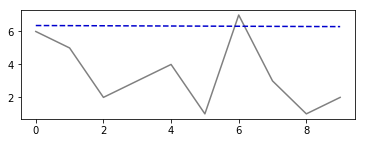

In [25]:
visual_validate(a+b*X[test_X],y[test_X],'Linear Regression [Baseline]')

### [ACF/PACF] Auto and Partial Auto Correlation Functions

__Formulas__

Normalize: $$ z_i=\frac{x_i-\min(x)}{\max(x)-\min(x)}$$
Covariance (sample): $$ \frac{\sum {(x-x_\mu)}\cdot \sum{(y-y_\mu)}}{n-1} $$
Variance (sample): $$ \sigma^2 = \frac{\sum{(x-x_\mu)^2}}{n-1} $$
ACF (1 variable): $$ r_{k} = \frac{\sum_{i=1}^{n-k}(y_{i} - \bar{y})(y_{i+k} - \bar{y})} {\sum_{i=1}^{n}(Y_{i} - \bar{y})^{2} } $$
PACF: $$ \frac{cov(y,x_3|x_1,x_2)}{\sqrt{var(y|x_1,x_2)\cdot var(x_3|x_1,x_2)}} $$

[Formula Links](https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula)

__Functions__

In [26]:
norm = lambda val: (val-val.min())/(val.max()-val.min())
variance = lambda val: np.sum(((val-val.mean())**2)/(len(val)-1))
dev = lambda val: variance(val)**.5

__Calculations__

In [27]:
values = pd.DataFrame(ba.values)
values[0] = pd.to_numeric(values[0],errors='coerce')
lag_values = pd.concat([values.shift(-3),values.shift(-2),values.shift(-1),values], axis=1).dropna()
lag_values.columns = ['t', 1,2,3]
lag_values.corr()

,t,1,2,3
t,1.000000,0.434542,0.348564,0.220210
1,0.434542,1.000000,0.429032,0.345030
2,0.348564,0.429032,1.000000,0.424448
3,0.220210,0.345030,0.424448,1.000000


__Gradient Descent__

In [28]:
x_merged = lag_values.drop(['t',3],axis=1).values
y_actual = lag_values['t'].values
theta = np.random.randn(2,1)

In [29]:
sgd = SGDRegressor(max_iter=1000)
sgd.fit(x_merged,y_actual)
sgd_intercept = sgd.intercept_
sgd_coefs = sgd.coef_

__Graph__

[Reference for Lag Plots](https://www.statisticshowto.datasciencecentral.com/lag-plot/)

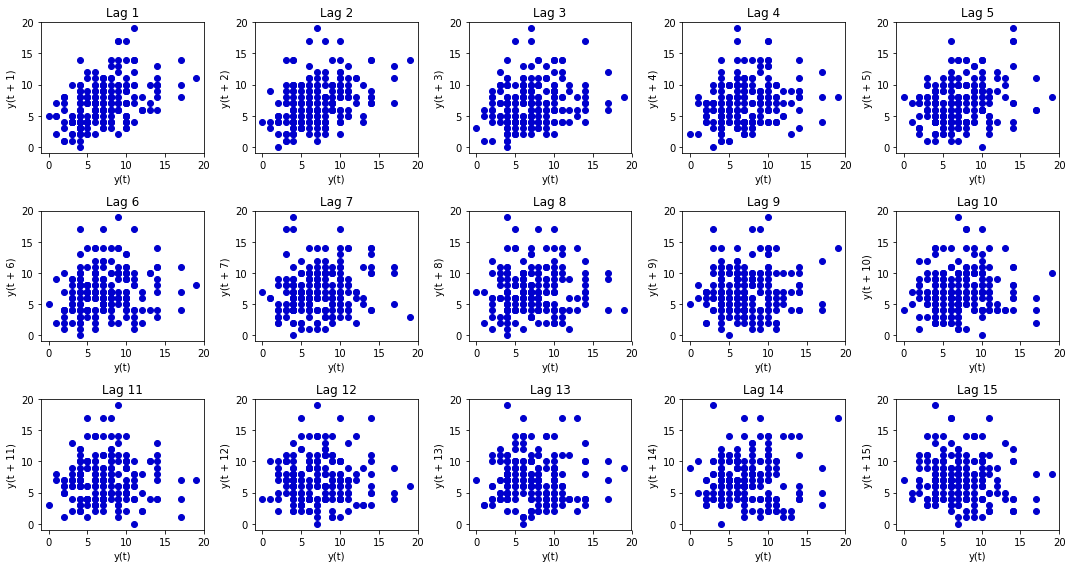

In [30]:
fig = plt.figure(figsize=(15,8))
for num in range(1,16):
    ax = fig.add_subplot(3,5,num)
    pd.plotting.lag_plot(ba,lag=num,c='mediumblue')
    ax.set_title('Lag {}'.format(num))
plt.tight_layout()
plt.show()

Lag one appears to be borderline linear (albeit with a small r-correlation value). Others appear more likely to be elliptical in nature which suggests a sinusoidal distribution.

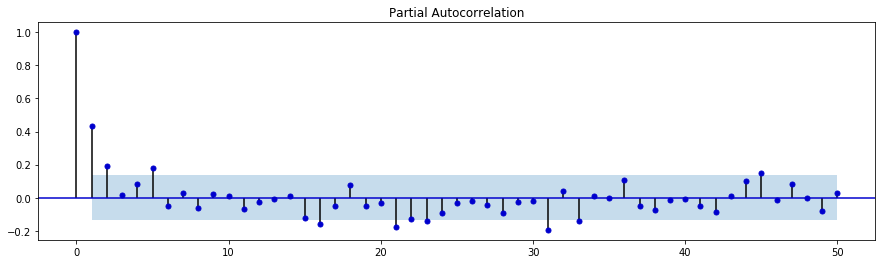

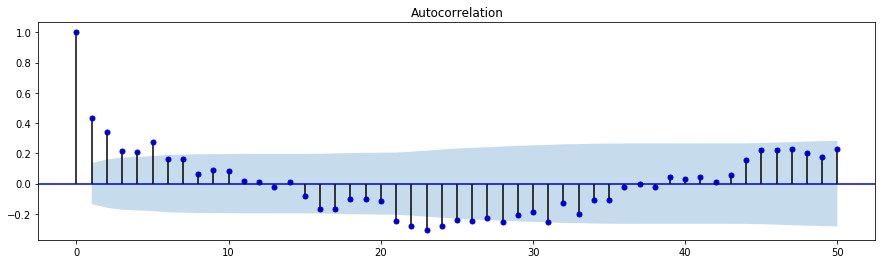

In [31]:
fig, ax = plt.subplots(figsize=(15, 4));plot_pacf(y,color='mediumblue',lags=50,ax=ax);plt.show()
fig, ax = plt.subplots(figsize=(15, 4));plot_acf(y,color='mediumblue',lags=50,ax=ax);plt.show()

### [RM] Rolling Mean Model

MA(3)
RMSE: 2.61413369821944


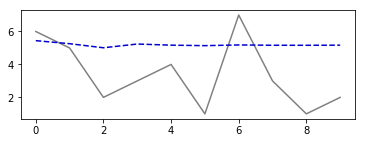

In [32]:
e,y_avg= np.random.random_sample(N)-.5,np.zeros(N)
lags = 1
for i in range(lags, N):
    if i < len(train_y):
        y_avg[i] = (train_y[i]+train_y[i-1]+train_y[i-2])/3
    else:
        y_avg[i] = (y_avg[i-1]+y_avg[i-2]+y_avg[i-3])/3
    prediction = y_avg[test_X]
visual_validate(prediction,test_y,'MA(3)')

### [AR] and [MA] Lags

AR Lag Plot


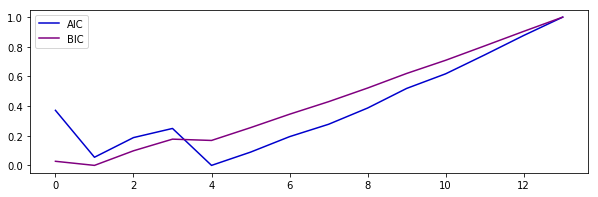

MA Lag Plot


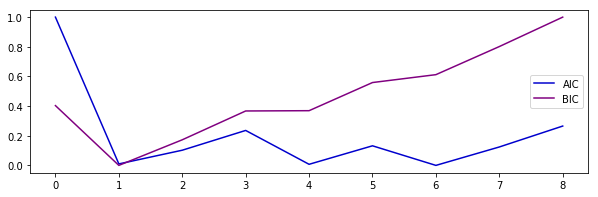

In [33]:
# Various algorithms for finding weight coefficients
solvers = ['lbfgs', 'bfgs', 'newton', 'nm', 'cg', 'ncg', 'powell']


df_resid,plot_aic,plot_bic,plot_RMSE = [],[],[],[]
for ar_val in range(1,15):
    order = (ar_val,0,0)
    model = ARIMA(list(train_y), order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_y))
    plot_aic.append(model_fit.aic)
    plot_bic.append(model_fit.bic)
    df_resid.append(model_fit.df_resid)
    plot_RMSE.append(RMSE(forecast[0],test_y))
df_resid,plot_aic,plot_bic,plot_RMSE = norm(np.array(df_resid)),norm(np.array(plot_aic)),norm(np.array(plot_bic)),norm(np.array(plot_RMSE))
print('AR Lag Plot')
plt.figure(figsize=(10,3))
plt.plot(plot_aic,color='mediumblue')
plt.plot(plot_bic,color='purple')
# plt.plot(plot_RMSE,color='darkred')
plt.legend(['AIC','BIC'])
plt.show()

df_resid,plot_aic,plot_bic,plot_RMSE = [],[],[],[]
for ma_val in range(1,10):
    try:
        order = (0,0,ma_val)
        model = ARIMA(list(train_y), order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_y))
        plot_aic.append(model_fit.aic)
        plot_bic.append(model_fit.bic)
        df_resid.append(model_fit.df_resid)
        plot_RMSE.append(RMSE(forecast[0],test_y))
    except Exception as e:
        print(e)
df_resid,plot_aic,plot_bic,plot_RMSE = norm(np.array(df_resid)),norm(np.array(plot_aic)),norm(np.array(plot_bic)),norm(np.array(plot_RMSE))
print('MA Lag Plot')
plt.figure(figsize=(10,3))
plt.plot(plot_aic,color='mediumblue')
plt.plot(plot_bic,color='purple')
# plt.plot(plot_RMSE,color='darkred')
plt.legend(['AIC','BIC'])
plt.show()

_AR lags appear to be most effective at 1,3,4. MA lags appear to be most effective at 1,4,6._

### [AR] Auto Regressive Model

__[Formula](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)__

$ \begin{equation*}  y_{t}=\phi_{0}+\phi_{1}y_{t-1}+\phi_{2}y_{t-2}+...+\epsilon_{t}  \end{equation*} $

__Example AR Model (Shift by 1):__

AR(1) [No Coefficients/No Forecasting]
RMSE: 2.8635642126552705


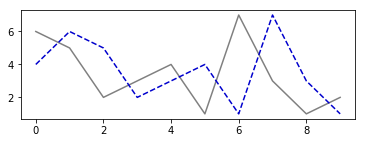

In [34]:
visual_validate(y[np.array(test_X)-1],y[test_X],'AR(1) [No Coefficients/No Forecasting]')

__AR(1)__

AR(1)
RMSE: 2.215031253297792


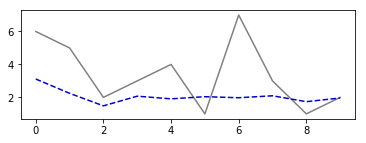

In [35]:
# AR model
y_reg = np.zeros(N)
lags = 1
coefs = pacf(y,nlags=lags, method='ols')
for i in range(lags, N):
    if i < len(train_y):
        y_reg[i] = coefs[0]+ coefs[1]*y[i-1] + e[i]
    else:
        y_reg[i] = coefs[0]+ coefs[1]*y_reg[i-1] + e[i] 
prediction = y_reg[test_X]
visual_validate(prediction,test_y,'AR(1)')

__AR(2)__

AR(2)
RMSE: 1.8025421433921107


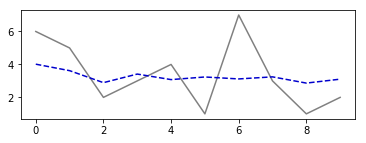

In [36]:
# Using PACF as weights (Practicing Regression-Not for actual analysis)
y_reg = np.zeros(N)
lags = 2
coefs = pacf(y,nlags=lags, method='ols')
for i in range(lags, N):
    if i < len(train_y):
        y_reg[i] = coefs[0]+ coefs[1]*y[i-1]+coefs[2]*y[i-2] + e[i]
    else:
        y_reg[i] = coefs[0]+coefs[1]*y_reg[i-1]+coefs[2]*y_reg[i-2] + e[i]
prediction = y_reg[test_X]
visual_validate(prediction,test_y,'AR(2)')

AR(2)
RMSE: 3.9164315105113157


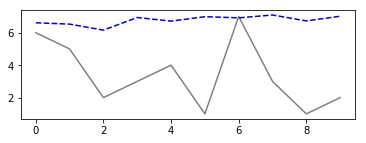

In [37]:
# Using SGD for Weights
y_reg = np.zeros(N)
lags = 2
coefs = sgd_coefs
intercept = sgd_intercept
for i in range(lags, N):
    if i < len(train_y):
        y_reg[i] = intercept+coefs[0]*x_merged[i][0]+coefs[1]*x_merged[i][1] + e[i]
    else:
        y_reg[i] = intercept+coefs[0]*y_reg[i-1]+coefs[1]*y_reg[i-2] + e[i]
prediction = y_reg[test_X]
visual_validate(prediction,test_y,'AR(2)')

__AR Model (14)__

AR(14) - Auto Pick
RMSE: 3.9795850608724654


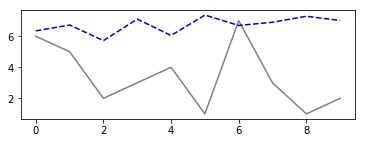

In [38]:
model = AR(train_y)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train_y), end=len(train_y)+len(test_y)-1, dynamic=False)
visual_validate(predictions,test_y,'AR({}) - Auto Pick'.format(model_fit.k_ar))

_The AR model defaulted to 14 lags. 14weeks/4.3 is approximately 3 months._

### [MA] Moving Average Errors

__[Formula](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)__

$ \begin{equation*}  y_{t}=\theta_{0}+\theta_{1}e_{t-1}+\theta_{2}e_{t-2}+...+\epsilon_{t}  \end{equation*} $

__MA(1)__

MA(1): Residual Errors Plot


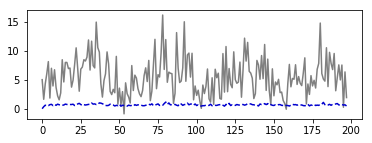

In [39]:
# AR(1) Predictions (Arbitrary prediction method)
y_prediction = np.zeros(N)
lags = 1
# coefs = pacf(y,nlags=lags, method='ols')
for i in range(lags, N):
    if i < len(train_y):
        y_prediction[i] = sgd_coefs[0]+ sgd_coefs[1]*y[i-1] + e[i]
    else:
        y_prediction[i] = sgd_coefs[0]+ sgd_coefs[1]*y_prediction[i-1] + e[i] 

# MA Residuals
error_actual = y-y_prediction
error_pred = np.zeros(N)
for i in range(lags, N):
    if i < len(train_y):
        error_pred[i] = coefs[0]+coefs[1]*y_prediction[i-1]
visual_validate(error_pred[train_X],error_actual[train_X],'MA({}): Residual Errors Plot'.format(lags),False)

### [ARIMA] Auto Regressive Integrated Moving Average Model

Notes for [ARIMA](https://people.duke.edu/~rnau/411arim.htm) [params](https://stats.stackexchange.com/questions/44992/what-are-the-values-p-d-q-in-arima)

In [40]:
# Best lags for AR and MA (After trial and error)
best_AR,trend,best_MA = 4,1,1
best_order = (best_AR,trend,best_MA)

ARIMA(4, 2, 1)
RMSE: 2.458817558841663


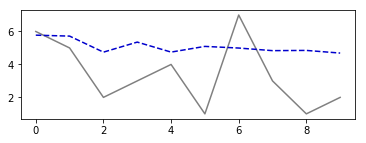

In [41]:
# Various algorithms for finding weight coefficients
solvers = ['lbfgs', 'bfgs', 'newton', 'nm', 'cg', 'ncg', 'powell']
model = ARIMA(list(train_y), order=best_order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_y))
visual_validate(forecast[0],test_y,'ARIMA{}'.format(best_order))
# model_fit.aic,model_fit.bic

ARIMA(4, 2, 1)
RMSE: 3.9217015853444863


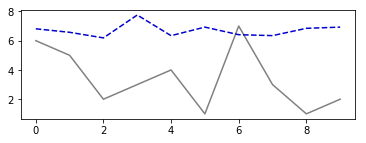

In [42]:
# Lags chosen via exploration
model = ARIMA(list(train_y), order=(14,1,7))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_y))
visual_validate(forecast[0],test_y,'ARIMA{}'.format(best_order))

### [[PROPHET]](https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/) Facebook's Forecasting Model

In [43]:
prophet_df = pd.DataFrame(ba);prophet_df.columns = ['y']

In [44]:
prophet_df['ds'] = prophet_df.index;prophet_df = prophet_df.reset_index();del prophet_df['index'];prophet_df = prophet_df[['ds','y']].iloc[train_X]

PROPHET
RMSE: 5.129523427896256


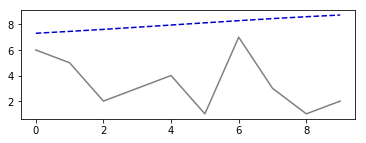

In [45]:
m = Prophet(weekly_seasonality=False, daily_seasonality=False,seasonality_prior_scale=0.1)
m.fit(prophet_df)
future = m.make_future_dataframe(periods=len(test_y))
p_forecast = m.predict(future)
visual_validate(p_forecast.yhat.values[test_X],test_y,'PROPHET')
# m.plot_components(p_forecast);

_Prophet does not appear to do very well with the practice test set_

# __Final Predictions: 2016__

_Based on my models, it seems like simple AR models performed better than combined ARIMA. Lags at 4 and 14 appear to be the strongest for AR. Prophet and ARIMA did not perform well on the practice test set so my assumption would be that an AR(14) or AR(4) model will perform best._

In [58]:
model_predictions,model_name = [],[]
test_accidentsdf = pd.read_csv('../data/odot/Multnomah-2016.csv',low_memory=False);accidentsdf.head(8)
usedcol = ['Crash ID','Crash Hour','Crash Day','Crash Month','Crash Year','Total Pedalcyclist Count',
           'Total Pedalcyclist Fatality Count','Total Pedalcyclist Non-Fatal Injury Count','Crash Type',
           'Collision Type','Median Type','Crash Severity','Intersection Type','Crash ID',
           'Nearest Intersecting Street Number','Road Character']
bikeaccident_test = test_accidentsdf[usedcol][test_accidentsdf['Total Pedalcyclist Count']>0].dropna().reset_index()
bikeaccident_test.index = pd.to_datetime(
    bikeaccident_test['Crash Year']*10000+bikeaccident_test['Crash Month']*100+bikeaccident_test['Crash Day'],
    format='%Y%m%d')
ba_test = bikeaccident_test['Total Pedalcyclist Count'].groupby(pd.Grouper(freq='W')).count()

[OLS]

In [59]:
X_final = np.array([i+y[-1] for i in range(1,len(ba_test))])
model_predictions.append(list(a+X_final*b))
model_name.append('Linear Regression')

[AR]

In [71]:
lags=[4,14]
for i in lags:
    order = (i,0,0)
    model = ARIMA(list(y), order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(ba_test))
    model_predictions.append(forecast[0])
    model_name.append('AR{}'.format(i))

[ARIMA]

In [69]:
order = (4,1,1)
model = ARIMA(list(y), order=order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(ba_test))
model_predictions.append(forecast[0])
model_name.append('ARIMA{}'.format(order))

In [ ]:
order = (14,1,7)
model = ARIMA(list(y), order=order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(ba_test))
model_predictions.append(forecast[0])
model_name.append('ARIMA{}'.format(order))

[PROPHET]

In [62]:
prophet_df_test = pd.DataFrame(ba_test);prophet_df_test.columns = ['y']
prophet_df_test['ds'] = prophet_df_test.index;prophet_df_test = prophet_df_test.reset_index();del prophet_df_test['index'];prophet_df_test = prophet_df_test[['ds','y']]
m = Prophet(weekly_seasonality=False, daily_seasonality=False,seasonality_prior_scale=0.1)
m.fit(prophet_df)
future = m.make_future_dataframe(periods=52)
p_forecast = m.predict(future)[-(len(ba_test)):]
model_predictions.append(p_forecast.yhat.values)
model_name.append('Prophet')

## Results

Final Predictions for 2016


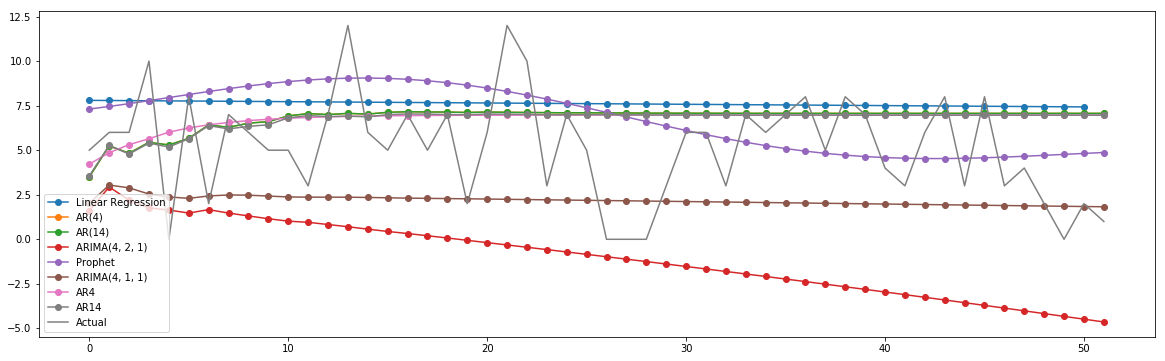

In [72]:
plt.figure(figsize=(20,6))
for i in range(len(model_predictions)):
    plt.plot(model_predictions[i],label=model_name[i],marker='o')
plt.plot(ba_test.values,label='Actual',color='gray')
plt.legend()
print('Final Predictions for 2016')
plt.show()